In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install git+https://github.com/forrestbao/pyeeg.git

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-88l8fw6i
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-88l8fw6i
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28121 sha256=4fb1291c71dcff1357805f116267211c6af3194b2c9c71d222908b8198f2e44d
  Stored in directory: /tmp/pip-ephem-wheel-cache-ds_q67o4/wheels/2d/3f/ad/106d4fc80b61d1ea1fc18e76e7439fd98aa043d83d58eae741
Successfully built pyeeg


In [ ]:
!pip install numpy==1.16.1
#import numpy as np

In [ ]:
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math
from sklearn.preprocessing import normalize

import os
import time

In [ ]:
#channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #15 Channels chosen to fit Emotiv Epoch+
channel = [1,2,4,5,8,10,15,21,22,25,26,27,28,31,32]
band = [4,8,13,22,30,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32']

#List of subjects

In [ ]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open('/content/drive/MyDrive/MTech_Project/data_preprocessed_python/s' + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;
            #data.shape

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))    
                start = start + step_size
                
        meta = np.array(meta)
        np.save('/content/drive/MyDrive/MTech_Project/processed_DEAP/s' + sub, meta, allow_pickle=True, fix_imports=True)


In [ ]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []

# save np.load
#np_load_old = np.load

# modify the default parameters of np.load
#np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

for subjects in subjectList:

    with open('/content/drive/MyDrive/MTech_Project/processed_DEAP/s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file)
        for i in range (0,sub.shape[0]):
            #print(sub.shape[0])
            if i % 8 == 0:
                #print("hey")
                #print(sub[i][0])
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])
            else:
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])

# restore np.load for future normal usage
#np.load = np_load_old

np.save('/content/drive/MyDrive/MTech_Project/data_training/data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/MTech_Project/label_training/label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save('/content/drive/MyDrive/MTech_Project/data_testing/data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/MTech_Project/label_testing/label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)



training dataset: (85400, 75) (85400, 4)
testing dataset: (12200, 75) (12200, 4)


In [ ]:
with open('/content/drive/MyDrive/MTech_Project/data_training/data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open('/content/drive/MyDrive/MTech_Project/label_training/label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
X = normalize(X)
Z = np.ravel(Y[:, [1]])

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

In [ ]:
import keras
import keras.backend as K
from keras.layers.convolutional import Conv1D
from keras.models import Sequential
from keras.utils import to_categorical 
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Model
import timeit
from keras.layers.convolutional import MaxPooling1D, ZeroPadding1D
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(Z)
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
x_train = np.array(X[:])

In [ ]:
with open('/content/drive/MyDrive/MTech_Project/data_testing/data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open('/content/drive/MyDrive/MTech_Project/label_testing/label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [1]])

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

In [ ]:
x_test = np.array(M[:])

In [ ]:
from keras.utils import to_categorical
y_test = to_categorical(L)
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [ ]:
x_train.shape

(85400, 75, 1)

In [ ]:
batch_size = 256
num_classes = 10
epochs = 200
input_shape=(x_train.shape[1], 1)

In [ ]:
print(input_shape)

(75, 1)


In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

In [ ]:
model = Sequential()
intput_shape=(x_train.shape[1], 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
#model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
#model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 75, 128)           512       
_________________________________________________________________
batch_normalization_6 (Batch (None, 75, 128)           512       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 37, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 37, 128)           49280     
_________________________________________________________________
batch_normalization_7 (Batch (None, 37, 128)           512       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 18, 128)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)             

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)


Epoch 1/200
334/334 [==============================] - 3s 8ms/step - loss: 2.0534 - accuracy: 0.2383
Epoch 2/200
334/334 [==============================] - 3s 8ms/step - loss: 1.8941 - accuracy: 0.2822
Epoch 3/200
334/334 [==============================] - 3s 8ms/step - loss: 1.8146 - accuracy: 0.3135
Epoch 4/200
334/334 [==============================] - 3s 8ms/step - loss: 1.7526 - accuracy: 0.3371
Epoch 5/200
334/334 [==============================] - 3s 8ms/step - loss: 1.6987 - accuracy: 0.3591
Epoch 6/200
334/334 [==============================] - 3s 8ms/step - loss: 1.6488 - accuracy: 0.3784
Epoch 7/200
334/334 [==============================] - 3s 8ms/step - loss: 1.6058 - accuracy: 0.3964
Epoch 8/200
334/334 [==============================] - 3s 8ms/step - loss: 1.5605 - accuracy: 0.4154
Epoch 9/200
334/334 [==============================] - 3s 8ms/step - loss: 1.5160 - accuracy: 0.4340
Epoch 10/200
334/334 [==============================] - 3s 8ms/step - loss: 1.4709 - accura

382/382 [==============================] - 1s 2ms/step - loss: 0.7430 - accuracy: 0.7961


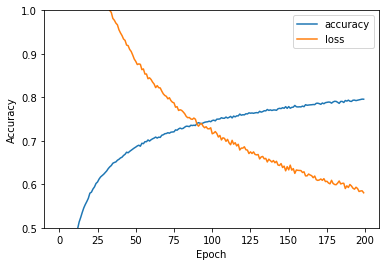

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='Upper right')

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)


In [ ]:
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.6190317273139954
Test accuracy: 0.8084426522254944


In [ ]:
A = model.predict(x_test)

In [ ]:
A[0]

array([3.9104124e-32, 5.4737509e-05, 1.6035015e-03, 2.5269753e-04,
       5.7713358e-05, 5.2189794e-06, 6.2019960e-04, 9.9549770e-01,
       1.8632810e-03, 4.4945878e-05], dtype=float32)

In [ ]:
np.round(A)

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)